# Week 4: NLP Disaster Tweets

## 1. Abstract
The widespread use of smartphones enables people to report observed emergencies in real-time. As a result, an increasing number of organizations, such as disaster relief agencies and news outlets, are interested in monitoring Twitter through various programs. However, determining whether someone’s words truly indicate a disaster is not always straightforward. For this reason, we have developed a Natural Language Processing (NLP) solution to automatically analyze the sentiment and content of thousands of tweets. The primary task of this NLP model is to identify and classify whether the tweet text describes an actual weather disaster.

## 2. Data

The dataset used for training and testing is sourced from Kaggle (https://www.kaggle.com/c/nlp-getting-started/data). Each sample in this dataset contains the following fields: the text of a tweet, a keyword extracted from the tweet (which may sometimes be blank), and the location from which the tweet was sent (also possibly blank). The corresponding values include: 

- **id**: A unique identifier for each tweet,  
- **text**: The content of the tweet,  
- **location**: The geographical location from which the tweet was sent (optional),  
- **keyword**: A specific keyword extracted from the tweet (optional),  
- **target**: Available only in `train.csv`, indicating whether the tweet is about a real disaster (1) or not (0).  

This structured dataset serves as the foundation for building and evaluating the classification models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

2024-12-12 16:00:47.690886: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 16:00:47.833786: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-12 16:00:50.891933: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### 2.1 Data Loading and Cleaning

In [2]:
# Load the training data
train = pd.read_csv('train.csv')
# Display data dimensions and a sample
print("Training Data Dimensions:", train.shape)
print("Sample of Training Data:")
train.head()

Training Data Dimensions: (7613, 5)
Sample of Training Data:


id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [3]:
print('Null Values')
train.isnull().sum()

Null Values


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

The test data consists of 3263 tweets that have the following features: ID, keyword, loctation, text (main body of tweet), and target. Few of the tweets have a keyword or location. There are 26 tweets with a missing keyword and 1105 (about 1/3) with a missing location.

In [4]:
test = pd.read_csv('test.csv')
print("Test Data Shape:", test.shape)
print("Test Data Example:")
test.head()

Test Data Shape: (3263, 4)
Test Data Example:


id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

In [5]:
print('Null Values')
test.isnull().sum()

Null Values


id             0
keyword       26
location    1105
text           0
dtype: int64

The dataset in this experiment is split into training and testing sets at a 7:3 ratio. This split is based on the ID.

In [6]:
#Analyze the data format submitted to Kaggle
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.head()

id  target
0   0       0
1   2       0
2   3       0
3   9       0
4  11       0

### 2.2 Exploratory Data Analysis (EDA)

In [7]:
train = train.replace(np.nan, 'None')
print("Unique Keywords in Train:", len(np.unique(train.keyword)))
np.unique(train.keyword)

Unique Keywords in Train: 222


array(['None', 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', '

In [10]:
train.keyword.value_counts()

keyword
None                     61
fatalities               45
deluge                   42
armageddon               42
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 222, dtype: int64

Text(0, 0.5, 'Frequency')

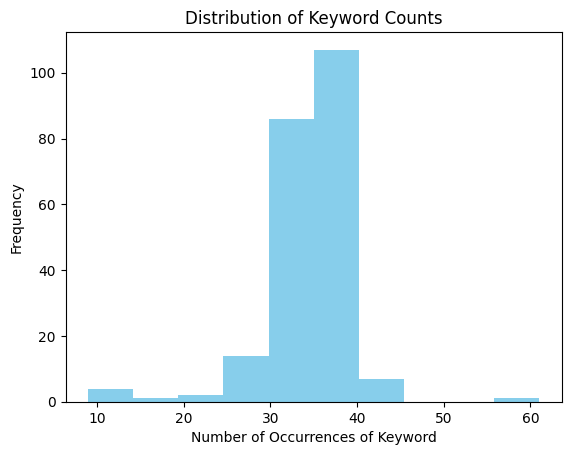

In [16]:
plt.hist(train.keyword.value_counts(), color='skyblue')
plt.title('Distribution of Keyword Counts')
plt.xlabel('Number of Occurrences of Keyword')
plt.ylabel('Frequency')


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'None'),
  Text(1, 0, 'fatalities'),
  Text(2, 0, 'deluge'),
  Text(3, 0, 'armageddon'),
  Text(4, 0, 'sinking'),
  Text(5, 0, 'damage'),
  Text(6, 0, 'harm'),
  Text(7, 0, 'body%20bags'),
  Text(8, 0, 'evacuate'),
  Text(9, 0, 'fear'),
  Text(10, 0, 'outbreak'),
  Text(11, 0, 'siren'),
  Text(12, 0, 'twister'),
  Text(13, 0, 'windstorm'),
  Text(14, 0, 'collided'),
  Text(15, 0, 'sinkhole'),
  Text(16, 0, 'sunk'),
  Text(17, 0, 'hellfire'),
  Text(18, 0, 'weapon'),
  Text(19, 0, 'weapons')])

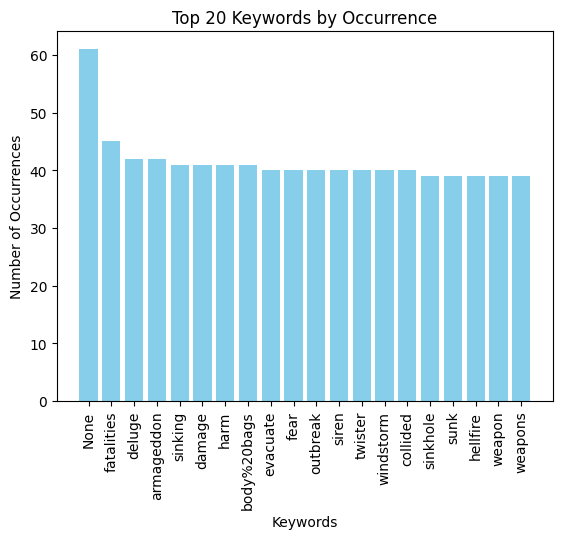

In [15]:
keyword_counts = train.keyword.value_counts().head(20)  # See the first 20 value counts
plt.bar(keyword_counts.index, keyword_counts.values, color='skyblue')
plt.title('Top 20 Keywords by Occurrence')
plt.xlabel('Keywords')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=90)


Text(0.5, 1.0, 'Word Cloud of Keywords')

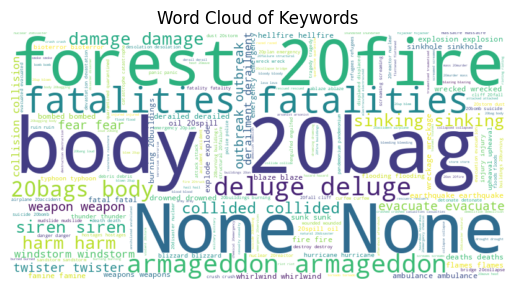

In [19]:
from wordcloud import WordCloud
keyword_text = ' '.join(train.keyword.dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(keyword_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Keywords')

While the keywords in the tweets show a fairly balanced distribution, the locations differ significantly. There are 3,342 unique locations, which, excluding the entries labeled 'None,' results in an average of roughly 2 tweets per unique location.

In [16]:
train.location.value_counts()

location
None                            2533
USA                              104
New York                          71
United States                     50
London                            45
                                ... 
Surulere Lagos,Home Of Swagg       1
MontrÌ©al, QuÌ©bec                 1
Montreal                           1
ÌÏT: 6.4682,3.18287                1
Lincoln                            1
Name: count, Length: 3342, dtype: int64

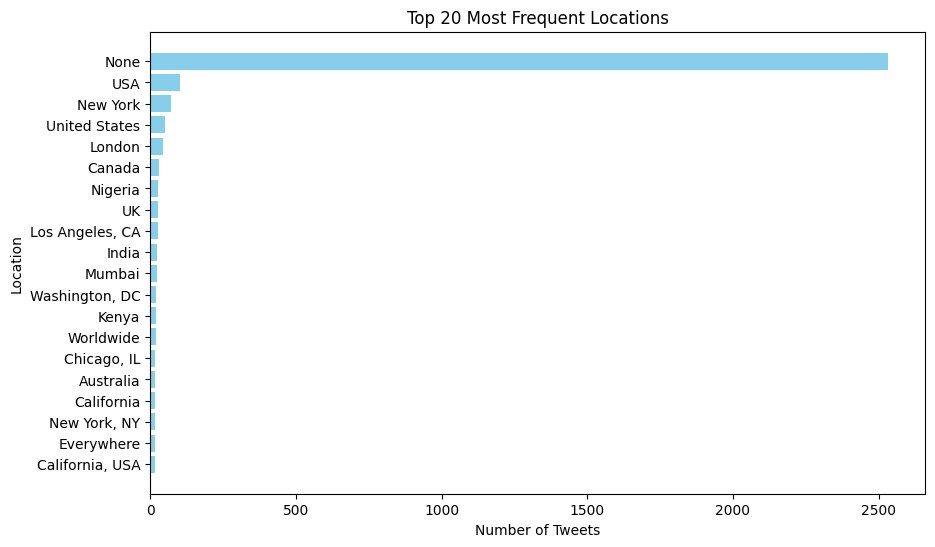

In [28]:
top_locations = train.location.value_counts().head(20)
plt.figure(figsize=(10, 6))
plt.barh(top_locations.index, top_locations.values, color='skyblue')  
plt.title('Top 20 Most Frequent Locations')
plt.xlabel('Number of Tweets')
plt.ylabel('Location')
plt.gca().invert_yaxis() 
plt.show()


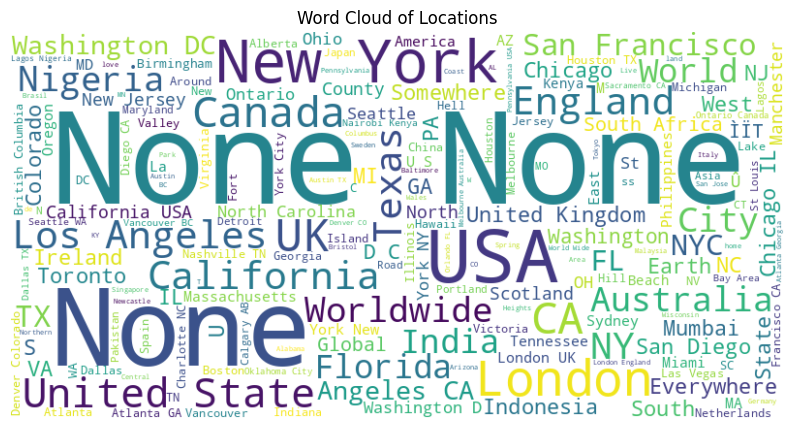

In [23]:
from wordcloud import WordCloud
location_text = ' '.join(train.location.dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(location_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Locations')
plt.show()


In [26]:
#Calculating the average number of characters in each tweet text body.
text_characters = [len(text) for text in train.text]
print("Average Tweet Length:", np.round(np.mean(text_characters),1), "characters")

Average Tweet Length: 101.0 characters


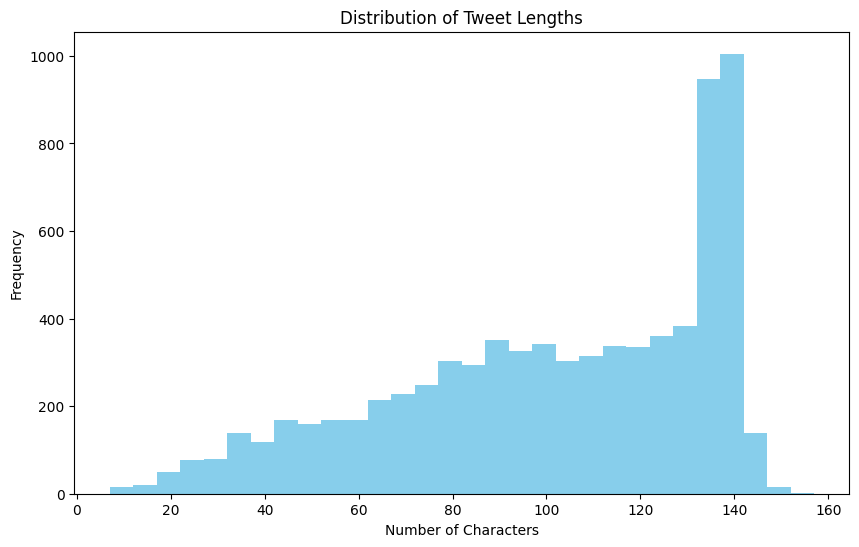

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(text_characters, bins=30, color='skyblue')  
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()


Examing test data types and replacing the float "NAN" with the string "None" for consistency in the keyword and location attribute data types.

In [8]:
test.dtypes

id           int64
keyword     object
location    object
text        object
dtype: object

In [9]:
test = test.replace(np.nan, 'None')

In [10]:
test.keyword.value_counts()

keyword
None             26
deluged          23
demolished       22
rubble           22
snowstorm        21
                 ..
threat            5
fatalities        5
forest%20fire     5
inundation        4
epicentre         1
Name: count, Length: 222, dtype: int64

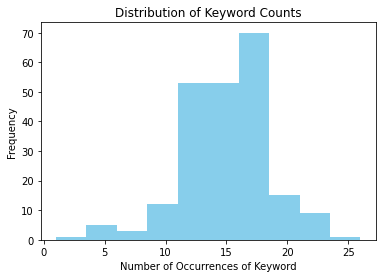

In [14]:
plt.hist(test.keyword.value_counts(), color='skyblue')  
plt.title('Distribution of Keyword Counts')
plt.xlabel('Number of Occurrences of Keyword')
plt.ylabel('Frequency')
plt.show()

In [15]:
test.location.value_counts()

location
None                      1105
New York                    38
USA                         37
Worldwide                   16
United States               15
                          ... 
Quezon City                  1
LanÌ¼s                       1
USA,Washington,Seattle       1
Roanoke, VA                  1
Brussels, Belgium            1
Name: count, Length: 1603, dtype: int64

In [16]:
text_characters = [len(text) for text in test.text]
print("Average Tweet Length:", np.round(np.mean(text_characters),1), "characters")

Average Tweet Length: 102.1 characters


The training set and the verification set are divided into 7:3

In [11]:
train_X, test_X, train_y, test_y = train_test_split(train['text'], train['target'], test_size=0.3, random_state=1)
print("train_X shape:", train_X.shape)  
print("test_X shape:", test_X.shape)   
print("train_y shape:", train_y.shape) 
print("test_y shape:", test_y.shape)    

train_X shape: (5329,)
test_X shape: (2284,)
train_y shape: (5329,)
test_y shape: (2284,)


### 2.3 Processing Tweet Text into Matrix Form


In [12]:
tfidf = TfidfVectorizer(stop_words='english', min_df = 2, max_df = 0.98)
train_tfidf = tfidf.fit_transform(train_X)
train_tfidf = np.array(train_tfidf.todense())
print("Embedded Training Data Shape:", train_tfidf.shape)
print("Example of Embedded Data:")
pd.DataFrame(train_tfidf).head()

Embedded Training Data Shape: (5329, 4987)
Example of Embedded Data:


0     1     2     3     4     5     6     7     8     9     ...  4977  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

   4978  4979  4980  4981      4982  4983  4984  4985  4986  
0   0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0  0.287921   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0  

[5 rows x 4987 columns]

In [13]:
test_tfidf = tfidf.transform(test_X)
test_tfidf = np.array(test_tfidf.todense())
print("Shape of embedded validation data:", test_tfidf.shape)

Shape of embedded validation data: (2284, 4987)


In [14]:
print("train_tfidf shape:", train_tfidf.shape)  # Shape before reshaping
print("test_tfidf shape:", test_tfidf.shape)    # Shape before reshaping

train_tfidf shape: (5329, 4987)
test_tfidf shape: (2284, 4987)


In [15]:
train_matrix = np.reshape(train_tfidf, (train_tfidf.shape[0], 1, train_tfidf.shape[1]))
test_matrix = np.reshape(test_tfidf, (test_tfidf.shape[0], 1, test_tfidf.shape[1]))
train_y = np.array(train_y)
test_y = np.array(test_y)
train_y = train_y.reshape(train_y.shape[0], 1)
test_y = test_y.reshape(test_y.shape[0], 1)


## 3. Model

### 3.1 LSTM

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC

# Define LSTM model
def lstm(input_shape):
    model = Sequential()
    
    # 1 LSTM layer with dropout
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True, activation='tanh'))
    model.add(Dropout(0.2))
    
    # 2 LSTM layer
    model.add(LSTM(64, return_sequences=False, activation='tanh'))
    model.add(Dropout(0.2))
    
    # Fully connected output layer
    model.add(Dense(1, activation='sigmoid'))  # Assum binary classification
    
    return model

# Input shape for LSTM
input_shape = (train_matrix.shape[1], train_matrix.shape[2])  # (1, num_features)

# Instantiate and compile the model
lstm_model = lstm(input_shape)
lstm_model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='binary_crossentropy', 
    metrics=[
        'accuracy', 
        Precision(name='precision'), 
        Recall(name='recall'), 
        AUC(name='auc')  # Area Under the Curve
    ]
)

# Display model summary
lstm_model.summary()
print("Expected input shape:", lstm_model.input_shape)

# Train the LSTM model
history = lstm_model.fit(
    train_matrix, train_y, 
    epochs=10, 
    batch_size=64, 
    validation_data=(test_matrix, test_y), 
    verbose=1
)

# Evaluate the model on the test 
test_loss, test_accuracy, test_precision, test_recall, test_auc = lstm_model.evaluate(test_matrix, test_y, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")
test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall + 1e-7)
print(f"Test F1 Score: {test_f1_score}")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 1, 128)            2619392   
                                                                 
 dropout_10 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_10 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2668865 (10.18 MB)
Trainable params: 2668865 (10.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Expected input

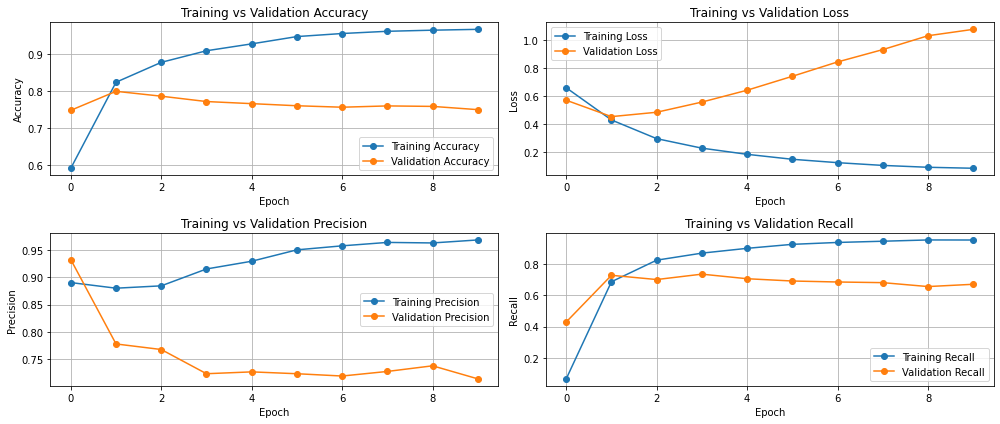

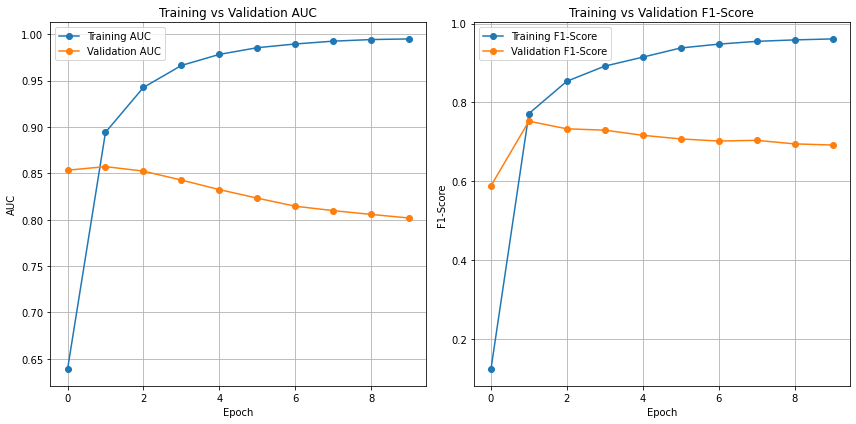

In [37]:
import matplotlib.pyplot as plt

# Plot Accuracy and Loss
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# Precision plot
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Training Precision', marker='o')
plt.plot(history.history['val_precision'], label='Validation Precision', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training vs Validation Precision')
plt.legend()
plt.grid(True)

# Recall plot
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Training Recall', marker='o')
plt.plot(history.history['val_recall'], label='Validation Recall', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Training vs Validation Recall')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot AUC and F1-Score
plt.figure(figsize=(12, 6))

# AUC plot
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'], label='Training AUC', marker='o')
plt.plot(history.history['val_auc'], label='Validation AUC', marker='o')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training vs Validation AUC')
plt.legend()
plt.grid(True)

# F1-Score plot (calculated manually during evaluation)
train_f1_scores = [
    2 * (p * r) / (p + r + 1e-7)
    for p, r in zip(history.history['precision'], history.history['recall'])
]
val_f1_scores = [
    2 * (p * r) / (p + r + 1e-7)
    for p, r in zip(history.history['val_precision'], history.history['val_recall'])
]

plt.subplot(1, 2, 2)
plt.plot(train_f1_scores, label='Training F1-Score', marker='o')
plt.plot(val_f1_scores, label='Validation F1-Score', marker='o')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Training vs Validation F1-Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### 3.2 More Complex LSTM

This enhanced LSTM model improves significantly over a basic LSTM by incorporating bidirectional LSTMs in the first two layers, allowing it to capture both past and future context in sequences. It features three stacked LSTM layers (two bidirectional and one standard), providing deeper temporal pattern learning. Regularization is enhanced with dropout layers (0.3 and 0.5) to prevent overfitting and batch normalization after each LSTM layer to stabilize and accelerate training. Additionally, a dense layer with 128 neurons is included to increase learning capacity, and metrics like AUC complement accuracy for robust evaluation, particularly in imbalanced datasets. These improvements make the model more powerful and versatile, albeit with higher computational requirements.

In [19]:
# Define a much more complex LSTM model
def complex_lstm(input_shape):
    model = Sequential()
    
    # 1 Bidirectional LSTM Layer
    model.add(Bidirectional(LSTM(128, return_sequences=True, activation='tanh'), input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    
    # 2 Bidirectional LSTM Layer
    model.add(Bidirectional(LSTM(64, return_sequences=True, activation='tanh')))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    
    # 3 LSTM Layer
    model.add(LSTM(64, return_sequences=False, activation='tanh'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    
    # Fully Connected Layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    
    return model

# Instantiate the model with the input shape
input_shape = (1, train_tfidf.shape[1]) 
complex_lstm_model = complex_lstm(input_shape)


# Display the model structure
complex_lstm_model.summary()

# Compile the model with additional metrics
complex_lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy', 
        Precision(name='precision'), 
        Recall(name='recall'), 
        'AUC'
    ]
)

# Train the model
history = complex_lstm_model.fit(
    train_matrix, train_y,
    epochs=10,  # Increased epochs for more complex model
    batch_size=32,
    validation_data=(test_matrix, test_y),
    verbose=1
)
# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall, test_auc = complex_lstm_model.evaluate(test_matrix, test_y, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

# Calculate F1-score
test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall + 1e-7)
print(f"Test F1 Score: {test_f1_score}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 1, 256)            5238784   
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 1, 256)            0         
                                                                 
 batch_normalization_3 (Bat  (None, 1, 256)            1024      
 chNormalization)                                                
                                                                 
 bidirectional_3 (Bidirecti  (None, 1, 128)            164352    
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 1, 128)            0         
                                                      

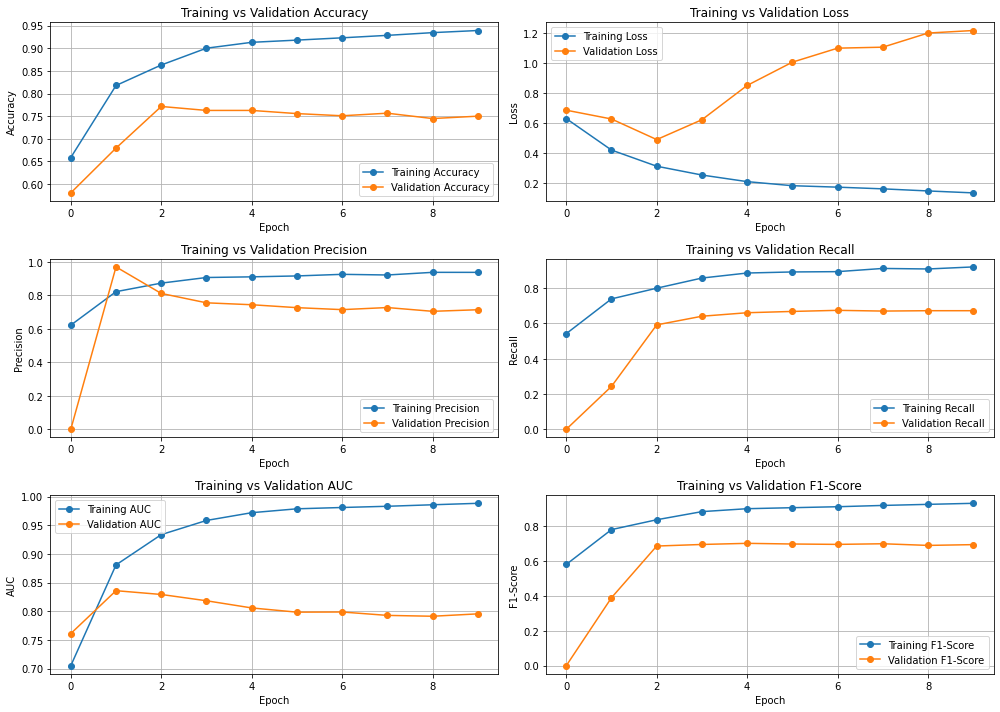

In [18]:
# Extract F1-scores
train_f1_scores = [
    2 * (p * r) / (p + r + 1e-7)
    for p, r in zip(history.history['precision'], history.history['recall'])
]
val_f1_scores = [
    2 * (p * r) / (p + r + 1e-7)
    for p, r in zip(history.history['val_precision'], history.history['val_recall'])
]

# Plot metrics
plt.figure(figsize=(14, 10))

# Accuracy plot
plt.subplot(3, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(3, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# Precision plot
plt.subplot(3, 2, 3)
plt.plot(history.history['precision'], label='Training Precision', marker='o')
plt.plot(history.history['val_precision'], label='Validation Precision', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training vs Validation Precision')
plt.legend()
plt.grid(True)

# Recall plot
plt.subplot(3, 2, 4)
plt.plot(history.history['recall'], label='Training Recall', marker='o')
plt.plot(history.history['val_recall'], label='Validation Recall', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Training vs Validation Recall')
plt.legend()
plt.grid(True)

# AUC plot
plt.subplot(3, 2, 5)
plt.plot(history.history['auc'], label='Training AUC', marker='o')
plt.plot(history.history['val_auc'], label='Validation AUC', marker='o')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training vs Validation AUC')
plt.legend()
plt.grid(True)

# F1-Score plot
plt.subplot(3, 2, 6)
plt.plot(train_f1_scores, label='Training F1-Score', marker='o')
plt.plot(val_f1_scores, label='Validation F1-Score', marker='o')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Training vs Validation F1-Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Hyperparameter fine-tuning


Trial 1/10: units_1=64, units_2=32, units_3=32, dropout_1=0.2, dropout_2=0.2, dropout_3=0.2, dense_units=64, learning_rate=0.001
Epoch 1: Loss = 0.6157, Accuracy = 0.6746, Val Loss = 0.6848, Val Accuracy = 0.5806
Epoch 2: Loss = 0.4092, Accuracy = 0.8238, Val Loss = 0.6293, Val Accuracy = 0.7198
Epoch 3: Loss = 0.3113, Accuracy = 0.8763, Val Loss = 0.4892, Val Accuracy = 0.7671
Epoch 4: Loss = 0.2503, Accuracy = 0.9039, Val Loss = 0.5802, Val Accuracy = 0.7649
Epoch 5: Loss = 0.1965, Accuracy = 0.9274, Val Loss = 0.7446, Val Accuracy = 0.7583
Epoch 6: Loss = 0.1689, Accuracy = 0.9296, Val Loss = 0.9017, Val Accuracy = 0.7531
Epoch 7: Loss = 0.1541, Accuracy = 0.9339, Val Loss = 0.9485, Val Accuracy = 0.7522
Epoch 8: Loss = 0.1379, Accuracy = 0.9416, Val Loss = 1.1396, Val Accuracy = 0.7474
Epoch 9: Loss = 0.1345, Accuracy = 0.9439, Val Loss = 1.1245, Val Accuracy = 0.7469
Epoch 10: Loss = 0.1273, Accuracy = 0.9521, Val Loss = 1.1840, Val Accuracy = 0.7531
Test Loss: 1.1840, Test Accur

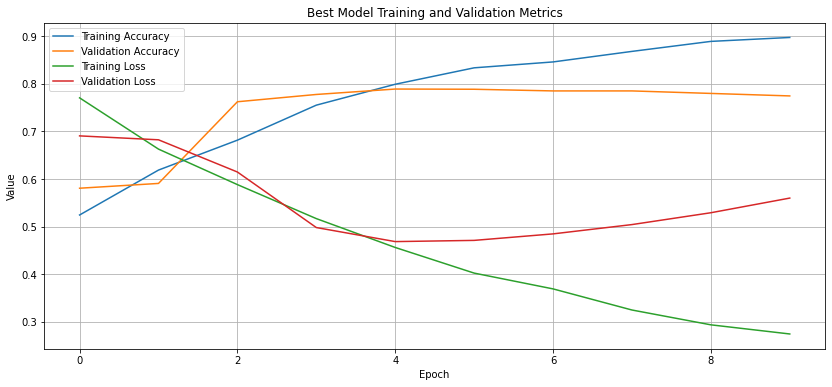

In [21]:
import itertools
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

# Define a custom callback to print progress
class PrintEveryEpoch(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}: Loss = {logs['loss']:.4f}, Accuracy = {logs['accuracy']:.4f}, "
              f"Val Loss = {logs['val_loss']:.4f}, Val Accuracy = {logs['val_accuracy']:.4f}")

# Define the LSTM model with many adjustable hyperparameters
def build_model(units_1, units_2, units_3, dropout_1, dropout_2, dropout_3, dense_units, learning_rate):
    model = Sequential()
    model.add(Bidirectional(LSTM(units_1, return_sequences=True, activation='tanh'), input_shape=(1, train_tfidf.shape[1])))
    model.add(Dropout(dropout_1))
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(units_2, return_sequences=True, activation='tanh')))
    model.add(Dropout(dropout_2))
    model.add(BatchNormalization())
    model.add(LSTM(units_3, return_sequences=False, activation='tanh'))
    model.add(Dropout(dropout_3))
    model.add(BatchNormalization())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), 'AUC']
    )
    return model

# Reduced hyperparameter combinations
hyperparameter_combinations = list(itertools.product(
    [64, 128],     # units_1
    [32, 64],      # units_2
    [32, 64],      # units_3
    [0.2, 0.3],    # dropout_1
    [0.2, 0.3],    # dropout_2
    [0.2, 0.3],    # dropout_3
    [64, 128],     # dense_units
    [1e-3, 1e-4]   # learning_rate
))[:10]  # Limit to 10 trials

# Training and validation results storage
results = []

# Perform the search
for i, (units_1, units_2, units_3, dropout_1, dropout_2, dropout_3, dense_units, learning_rate) in enumerate(hyperparameter_combinations):
    print(f"\nTrial {i + 1}/{len(hyperparameter_combinations)}: "
          f"units_1={units_1}, units_2={units_2}, units_3={units_3}, "
          f"dropout_1={dropout_1}, dropout_2={dropout_2}, dropout_3={dropout_3}, "
          f"dense_units={dense_units}, learning_rate={learning_rate}")
    
    # Build and train the model
    model = build_model(units_1, units_2, units_3, dropout_1, dropout_2, dropout_3, dense_units, learning_rate)
    history = model.fit(
        train_matrix, train_y,
        validation_data=(test_matrix, test_y),
        epochs=10,
        batch_size=32,
        callbacks=[PrintEveryEpoch()],
        verbose=0
    )
    
    # Evaluate the model
    test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_matrix, test_y, verbose=0)
    f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall + 1e-7)
    
    # Store the results
    results.append({
        'trial': i + 1,
        'hyperparameters': {
            'units_1': units_1, 'units_2': units_2, 'units_3': units_3,
            'dropout_1': dropout_1, 'dropout_2': dropout_2, 'dropout_3': dropout_3,
            'dense_units': dense_units, 'learning_rate': learning_rate
        },
        'metrics': {
            'test_loss': test_loss, 'test_accuracy': test_accuracy,
            'test_precision': test_precision, 'test_recall': test_recall,
            'test_auc': test_auc, 'f1_score': f1_score
        }
    })

    # Print trial results
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, "
          f"Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, "
          f"AUC: {test_auc:.4f}, F1 Score: {f1_score:.4f}")

# Find the best trial
best_trial = max(results, key=lambda x: x['metrics']['test_accuracy'])
print("\nBest Trial:")
print(f"Hyperparameters: {best_trial['hyperparameters']}")
print(f"Metrics: {best_trial['metrics']}")

# Plot the training history of the best trial
plt.figure(figsize=(14, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Best Model Training and Validation Metrics')
plt.legend()
plt.grid(True)
plt.show()

## 4. Conclusion
In this project, we conducted an in-depth study on the effectiveness of using LSTM for classifying disaster-related tweets. The results indicate that compared to single-layer networks, more complex multi-layer deep models demonstrate significant advantages in capturing temporal dependencies and handling complex sequential features. These multi-layer architectures can uncover hidden patterns in tweets, thereby improving classification accuracy. However, we also found that complex LSTM models are highly sensitive to hyperparameter settings, requiring greater computational resources and expertise for training and tuning, which increases the difficulty of successfully deploying such networks. The findings suggest that with proper model architecture design and meticulous hyperparameter optimization, LSTM can provide highly effective technical support for rapid responses in real-world crisis scenarios.

## 5.Reference 

[1] https://github.com/rsreetech/DisasterTweetClassification<br>
[2] https://github.com/cadenzonnefeld/NaturalDisasterTweetClassification/tree/main<br>
[3] https://github.com/tarunannapareddy/Natural-Language-Processing-with-Disaster-Tweets<br>
[4] https://github.com/zeyongj/Natural-Language-Processing-with-Disaster-Tweets<br>
[5] https://github.com/AdhamAfis/Natural-Language-Processing-with-Disaster-Tweets<br>
[6] https://github.com/imene-swaan/Natural-Language-Processing-with-Disaster-Tweets<br>
[7] https://github.com/tarunannapareddy/Natural-Language-Processing-with-Disaster-Tweets<br>
[8] https://github.com/canaveensetia/udacity-disaster-response-pipeline<br>
[9] https://github.com/Mukilan-Krishnakumar/NLP_With_Disaster_Tweets<br>
Reference: While completing assignments, I might encounter some errors, which could be caused by a Python library that I am not familiar with. In such cases, I try to ask ChatGPT about the specific purpose and structural composition of the Python library.